In [1]:
import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle as pickle

In [2]:
import prince_cr.config
from prince_cr import core, util, photonfields, cross_sections
from prince_cr import util as pru

# **Important**: Run `Create_Kernel.ipynb` before trying this example

# Reload the pickled kernel

You need to reload the kenrel that was pickled in the example in   `examples/Create_Kernel.ipynb`

Adjust the path to where you saved it to

In [3]:
%%time
target_path = '../'
with open(target_path + 'prince_run_talys_test.ppo','rb') as thefile:
    prince_run = pickle.load(thefile)

CPU times: user 239 ms, sys: 1.09 s, total: 1.33 s
Wall time: 2.16 s


# Run a solver using the loaded kernel

**Note:** We use a backward differentiation solver (BDF) here (`UHECRPropagationSolverBDF`)  
There are other options in `prince/solvers`, however these are not robustly tested.  
**So when in doubt use BDF**

In [4]:
from prince_cr.solvers import UHECRPropagationSolverBDF
from prince_cr.cr_sources import AugerFitSource, RigdityCutoffSource

**Note:** The photonfield was set together with the solver in `examples/Create_Kernel.ipynb`

However we can still replace it here:

In [58]:
pf_gilmore = photonfields.CombinedPhotonField(
    [photonfields.CMBPhotonSpectrum, photonfields.CIBGilmore2D]
)
prince_run.int_rates.photon_field = pf_gilmore

**Step 1:** Initiate solver class

In [59]:
solver = UHECRPropagationSolverBDF(
    initial_z=1.0,
    final_z=0.0,
    prince_run=prince_run,
    enable_pairprod_losses=True,
    enable_adiabatic_losses=True,
    enable_injection_jacobian=True,
    enable_partial_diff_jacobian=True,
)

**Step 2:** Create a source class and add it to the solver

**Note:** There are more source classes defined in `prince/sources.py`

In [66]:
rmax = 10**9.52
gamma = 0.9
total_norm = 1e-50

f_hydrogen = 0.0
f_helium = 67.3
f_nitrogen = 28.1
f_silicon = 4.6
f_iron = 0.0

# NOTE: You can add as much as you want here.
# you can also add several source classes. But that will be slower, if there are many
solver.add_source_class(
    AugerFitSource(
        prince_run,
        norm=total_norm,
        params={
            101: (gamma, rmax, f_hydrogen),
            402: (gamma, rmax, f_helium),
            1407: (gamma, rmax, f_nitrogen),
            2814: (gamma, rmax, f_silicon),
            5626: (gamma, rmax, f_iron),
        },
        m = ("simple", -3),
    )
)

**Note:** We add here only one source, but one could in principle add any number of sources here  
(For a large number of different source classes, the solver will get slow)

**Step 3:** Run the solver

In [67]:
%time solver.solve(dz=1e-3,verbose=False,progressbar=True)

1007it [00:22, 44.55it/s]                            

CPU times: user 4min 29s, sys: 598 ms, total: 4min 30s
Wall time: 24.7 s


# Now plot the result

To compare the results to data one has to obtain the 
[*prince_analysis_tools*](https://github.com/joheinze/PriNCe-analysis-tools) package and
add it to the `PYTHONPATH` as shown below.

In [68]:
# Make sure the
import sys

sys.path.append("../../PriNCe-analysis-tools/")

In [69]:
from prince_analysis_tools.spectra import auger2015, auger2017

data = auger2015
data_label = "Auger 2017"

First normalize roughly to the spectrum

In [70]:
result = solver.res

edata = auger2015["energy"]
norm = auger2015["spectrum"][17] / result.get_solution_group("CR", egrid=edata)[1][17]
print(f"{norm:.2e}")

result = result * norm

3.26e+04


### Plot the spectrum

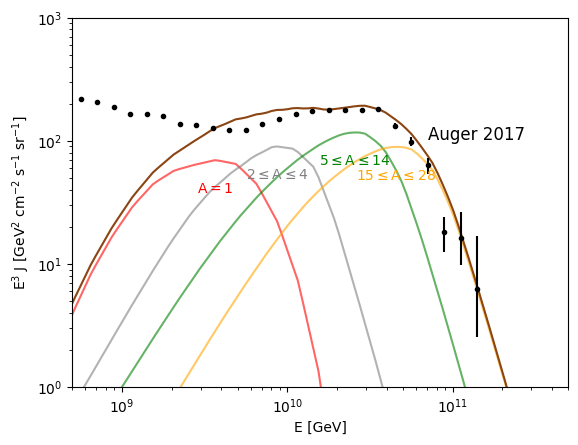

In [71]:
import matplotlib.pyplot as plt

ncoid2sref = result.spec_man.ncoid2sref
A = lambda x: ncoid2sref[x].A

for group, color, label, loffset in zip(
    [(A, 1, 1), (A, 2, 4), (A, 5, 14), (A, 15, 28), (A, 29, 56)],
    ["red", "gray", "green", "orange", "blue"],
    [
        r"$\mathrm{A} = 1$",
        r"$2 \leq \mathrm{A} \leq 4$",
        r"$5 \leq \mathrm{A} \leq 14$",
        r"$15 \leq \mathrm{A} \leq 28$",
        r"$29 \leq \mathrm{A} \leq 56$",
    ],
    [0, 0, 0, 0, 0],
):

    energy, spectrum = result.get_solution_group(group)
    l = plt.loglog(energy, spectrum, label=label, c=color, alpha=0.6)
    maxidx = spectrum.argmax()
    loc = (energy[maxidx + loffset], spectrum[maxidx + loffset] / 1.5)

    # only plot annotations, if they are roughly within plot range
    # otherwise there are clipping errors
    if 5e8 < loc[0] < 5e11 and 1e0 < loc[1] < 1e3:
        plt.annotate(
            label,
            loc,
            color=color,
            weight="bold",
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
        )

energy, spectrum = result.get_solution_group("CR")
l = plt.loglog(energy, spectrum, c="saddlebrown")

plt.errorbar(
    data["energy"],
    data["spectrum"],
    yerr=(data["lower_err"], data["upper_err"]),
    fmt="o",
    color="black",
    label=data_label,
    markersize=3,
)
plt.annotate(
    data_label,
    (data["energy"][-4], data["spectrum"][-4] * 1.5),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="bottom",
)
# plt.legend(ncol=1, loc='lower left', fontsize='small')

plt.xlim(5e8, 5e11)
plt.ylim(1e0, 1e3)

plt.ylabel(r"E$^3$ J [GeV$^{2}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]")
plt.xlabel(r"E [GeV]")

plt.show()

### Plot the composition

In [23]:
from prince_analysis_tools.xmax import XmaxSimple
from prince_analysis_tools.spectra import Xmax2015, Xmax2017, XRMS2015, XRMS2017

Helper functions for plotting

In [24]:
# %load ../scripts/xmax_plot.py
def make_error_boxes(
    xdata, ydata, xerror, yerror, facecolor="r", edgecolor="None", alpha=0.5
):

    ax = plt.gca()
    from matplotlib.collections import PatchCollection
    from matplotlib.patches import Rectangle

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(
        errorboxes, facecolor=facecolor, alpha=alpha, edgecolor=edgecolor
    )

    # Add collection to axes
    ax.add_collection(pc)


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Plot the mean $\langle X_\mathrm{max} \rangle$

/home/anatoli/devel/PriNCe/src/prince_cr/solvers/propagation.py:151: RuntimeWarning: invalid value encountered in divide
  average = (lnA[:, np.newaxis] * spectra).sum(axis=0) / spectra.sum(axis=0)
/home/anatoli/devel/PriNCe/src/prince_cr/solvers/propagation.py:152: RuntimeWarning: invalid value encountered in divide
  variance = (lnA[:, np.newaxis] ** 2 * spectra).sum(axis=0) / spectra.sum(


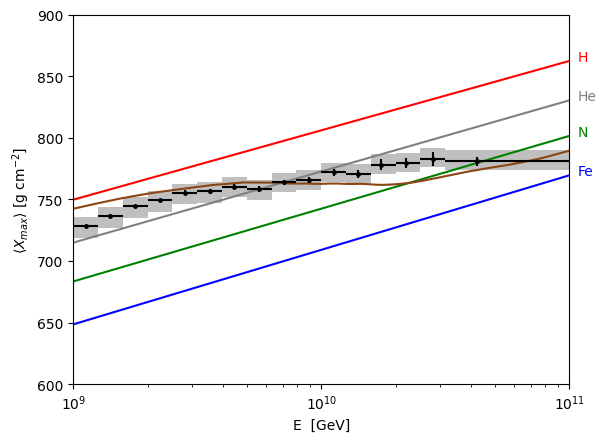

In [25]:
deltaE = 0.0
xshift = 0.0
model = XmaxSimple(model=XmaxSimple.EPOSLHC)
data = Xmax2017
data_label = r"\langle Xmax \rangle Auger 2017"

egrid, average, variance = result.get_lnA(
    [el for el in result.known_species if el >= 100]
)
energy = egrid
energy *= 1 + deltaE
mean_lnA = average
sigma_lnA = variance

import matplotlib.pyplot as plt

# plot the reference models
for A, c, name in zip(
    [1, 4, 14, 56], ["red", "gray", "green", "blue"], ["H", "He", "N", "Fe"]
):
    Xmax = model.get_mean_Xmax(np.log(A), energy)
    plt.semilogx(energy, Xmax, color=c)
    idx = find_nearest(energy, 1e11)
    plt.annotate(name, (energy[idx + 1], Xmax[idx]), color=c, annotation_clip=False)

Xmax = model.get_mean_Xmax(mean_lnA, energy)
plt.semilogx(energy, Xmax, color="saddlebrown", ls="solid")

xerr = np.array((data["energy_Low"], data["energy_Up"]))
yerr = np.array((data["sys_Low"], data["sys_Up"]))
make_error_boxes(data["energy"], data["val"], xerr, yerr, facecolor="gray")

if xshift > 0:
    xcorr = xshift * data["sys_Up"]
else:
    xcorr = xshift * data["sys_Low"]

plt.errorbar(
    data["energy"],
    data["val"] + xcorr,
    xerr=(data["energy_Low"], data["energy_Up"]),
    yerr=(data["stat"], data["stat"]),
    fmt="o",
    markersize=2.5,
    label=data_label,
    c="black",
)

plt.xlim(1e9, 1e11)
plt.ylim(600, 900)
plt.xlabel("E  [GeV]")
plt.ylabel(r"$\langle X_{max} \rangle$ [g cm$^{-2}$]")

plt.show()

### Plot the variance $\sigma(X_\mathrm{max})$

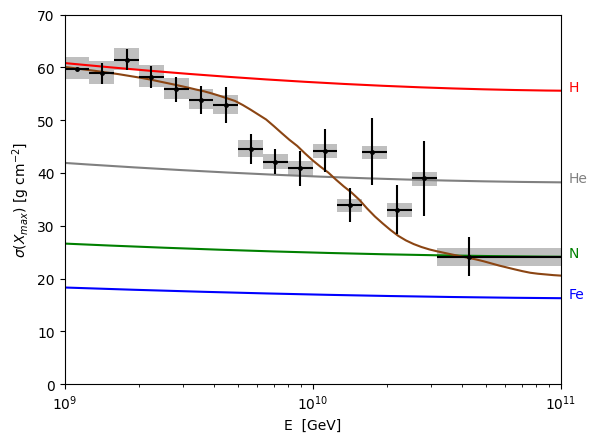

In [26]:
deltaE = 0.0
xshift = 0.0
model = XmaxSimple(model=XmaxSimple.EPOSLHC)
data = XRMS2017
data_label = r"\langle Xmax \rangle Auger 2017"

egrid, average, variance = result.get_lnA(
    [el for el in result.known_species if el >= 100]
)
energy = egrid
energy *= 1 + deltaE
mean_lnA = average
var_lnA = variance

import matplotlib.pyplot as plt

for A, c, name in zip(
    [1, 4, 14, 56], ["red", "gray", "green", "blue"], ["H", "He", "N", "Fe"]
):
    sigmaXmax, sigmaXmax_part = np.sqrt(model.get_var_Xmax(np.log(A), 0.0, energy))
    plt.semilogx(energy, sigmaXmax, color=c)
    idx = find_nearest(energy, 1e11)
    plt.annotate(
        name, (energy[idx + 1], sigmaXmax[idx]), color=c, annotation_clip=False
    )

sigmaXmax, sigmaXmax_part = np.sqrt(model.get_var_Xmax(mean_lnA, var_lnA, energy))
plt.semilogx(energy, sigmaXmax, color="saddlebrown", ls="solid")
#     plt.semilogx(energy,sigmaXmax_part, color = 'saddlebrown', ls ='dashed')

xerr = np.array((data["energy_Low"], data["energy_Up"]))
yerr = np.array((data["sys_Low"], data["sys_Up"]))
make_error_boxes(data["energy"], data["val"], xerr, yerr, facecolor="gray")

if xshift > 0:
    xcorr = xshift * data["sys_Up"]
else:
    xcorr = xshift * data["sys_Low"]

plt.errorbar(
    data["energy"],
    data["val"] + xcorr,
    xerr=(data["energy_Low"], data["energy_Up"]),
    yerr=(data["stat"], data["stat"]),
    fmt="o",
    markersize=2.5,
    label="Xmax Auger 2015",
    c="black",
)

plt.xlim(1e9, 1e11)
plt.ylim(0, 70)
plt.xlabel("E  [GeV]")
plt.ylabel(r"$\sigma( X_{max})$ [g cm$^{-2}$]")

plt.show()

### Cosmogenic Neutrinos

In [44]:
np.array(IClimit9year["energy"])

array([1.58489000e+06, 1.99526000e+06, 2.51189000e+06, 3.16228000e+06,
       3.98107000e+06, 5.01187001e+06, 6.30957000e+06, 7.94328001e+06,
       1.99526000e+07, 5.01187001e+07, 1.25893000e+08, 3.16228000e+08,
       7.94328001e+08, 1.99526000e+09, 5.01187001e+09, 1.25892999e+10,
       3.16227999e+10, 7.94327997e+10])

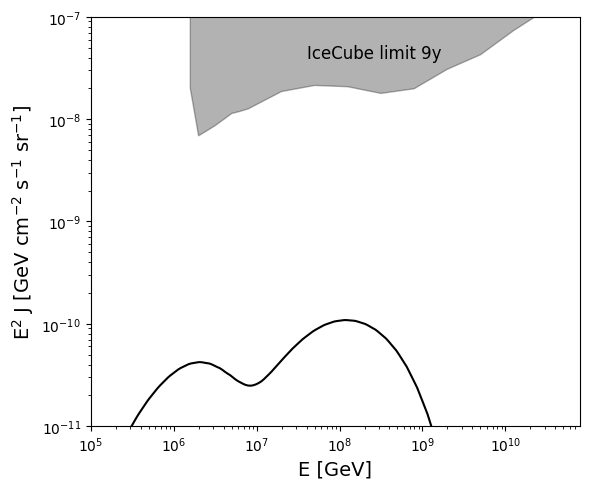

In [47]:
plt.figure(figsize=(6, 5))

alpha = 0.3
handles = []

egrid, spec = result.get_solution_group("nu", epow=2)
plt.loglog(egrid, spec, c="black", label="best fit")

from prince_analysis_tools.spectra import IClimit2017, IClimit2017GRB, IClimit9year
from prince_analysis_tools.spectra import IClimit9year_new as IClimit9year

plt.fill_between(
    np.array(IClimit9year["energy"]),
    np.ones_like(IClimit9year["energy"]),
    np.array(IClimit9year["limit"]),
    color="black",
    alpha=0.3,
)
plt.annotate("IceCube limit 9y", (4e7, 4e-8), fontsize="large")

plt.ylim(1e-11, 1e-7)
plt.xlim(1e5, IClimit9year["energy"][-1].value)

plt.ylabel("E$^2$ J [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]", fontsize=14)
plt.xlabel("E [GeV]", fontsize=14)

plt.tight_layout()

plt.show()